In [1]:
# pip install causal-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# 데이터 로드 및 전처리
df = pd.read_csv("training_data.csv")
df = df.drop(columns=["Unnamed: 0", "label"])
data_np = df.values
labels = df.columns.tolist()

# PC 알고리즘 실행
cg = pc(data=data_np, indep_test_func=fisherz, alpha=0.01)

# networkx 그래프로 변환
G = cg.to_nx_graph()


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Depth=6, working on node 12: 100%|██████████| 13/13 [00:00<00:00, 1129.09it/s]


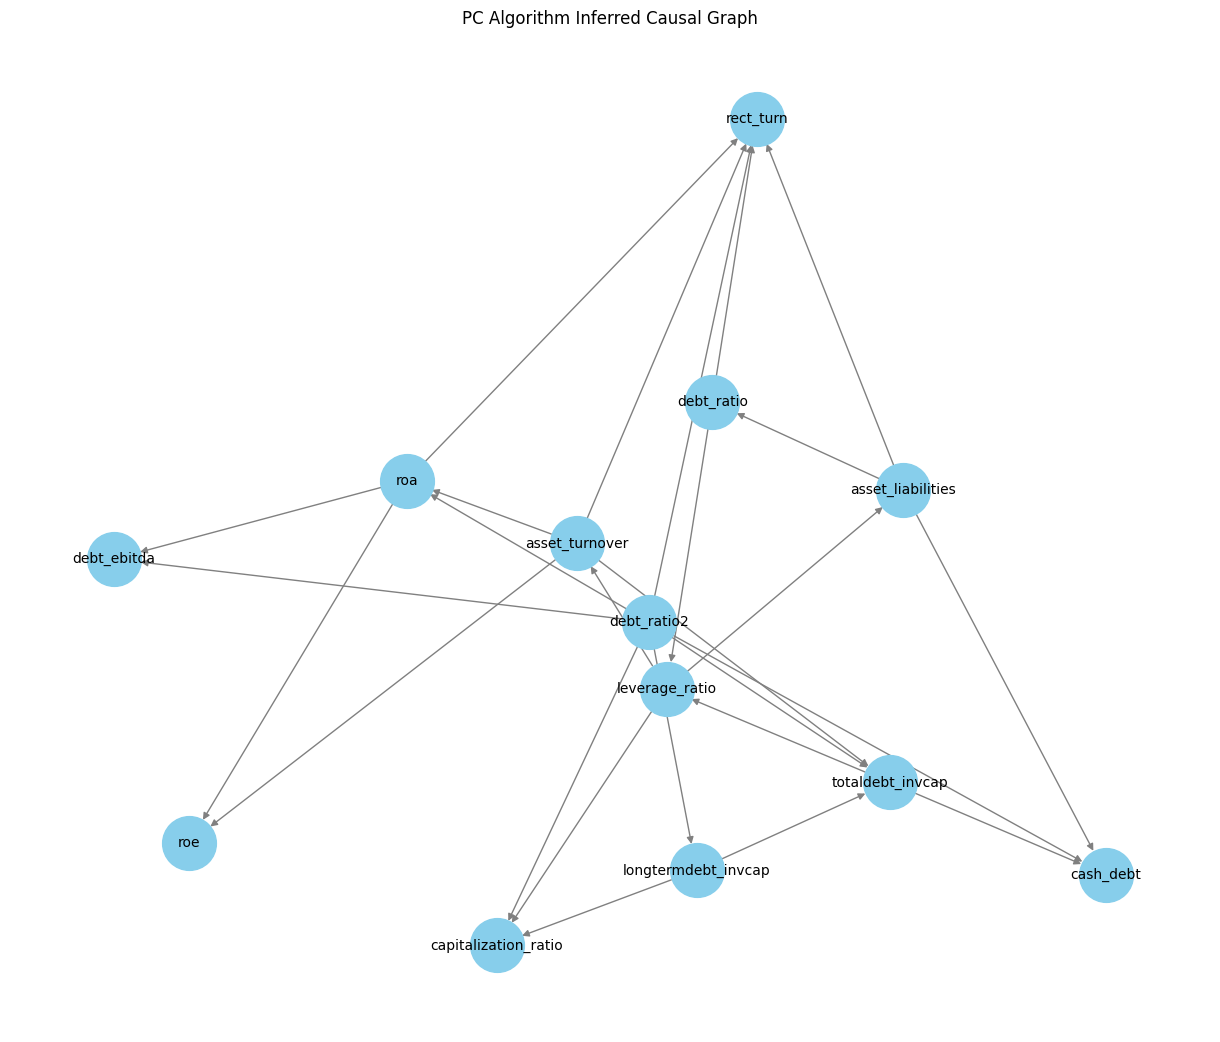

In [3]:
# 3. 네트워크 그래프 객체 수동 생성
G = nx.DiGraph()
for i, node_i in enumerate(labels):
    G.add_node(node_i)

# 4. 엣지 추가 (cg.G.graph는 인접 행렬)
for i in range(len(labels)):
    for j in range(len(labels)):
        if cg.G.graph[i, j] == 1:  # i → j 방향 간선
            G.add_edge(labels[i], labels[j])

# 5. 시각화
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1500, font_size=10,
        node_color='skyblue', edge_color='gray', arrows=True)
plt.title("PC Algorithm Inferred Causal Graph")
plt.show()

In [4]:
# --- 엣지 개수 세기 ---
num_edges = G.number_of_edges()
print(f"엣지 개수: {num_edges}")

# 엣지 리스트 출력 (원하면)
print("엣지 목록:")
for u, v in G.edges():
    print(f"{u} -> {v}")

엣지 개수: 26
엣지 목록:
leverage_ratio -> asset_liabilities
leverage_ratio -> asset_turnover
leverage_ratio -> capitalization_ratio
asset_liabilities -> debt_ratio
asset_liabilities -> cash_debt
asset_liabilities -> rect_turn
asset_turnover -> roe
asset_turnover -> roa
asset_turnover -> totaldebt_invcap
asset_turnover -> rect_turn
debt_ratio -> leverage_ratio
debt_ratio -> rect_turn
debt_ratio2 -> roa
debt_ratio2 -> capitalization_ratio
debt_ratio2 -> longtermdebt_invcap
debt_ratio2 -> totaldebt_invcap
debt_ratio2 -> cash_debt
debt_ratio2 -> debt_ebitda
debt_ratio2 -> rect_turn
roa -> roe
roa -> debt_ebitda
roa -> rect_turn
longtermdebt_invcap -> capitalization_ratio
longtermdebt_invcap -> totaldebt_invcap
totaldebt_invcap -> leverage_ratio
totaldebt_invcap -> cash_debt


In [7]:
# 5.5) |corr| 상위 15개 간선 CSV 저장 (출발 노드 | 상관계수 | 도착 노드)
from pathlib import Path
import pandas as pd

# 1) 상관계수 행렬 계산
# df는 원본 데이터프레임 (label 포함)
corr = df.corr()

# 2) G에서 추출한 간선에 대해 corr 값 매핑
edges_all = []
for u, v in G.edges():
    if u in corr.columns and v in corr.columns:
        w = corr.loc[u, v]
        edges_all.append((u, v, float(w)))

if len(edges_all) == 0:
    print("경고: 그래프에 간선이 없어 CSV를 생성하지 않았습니다.")
else:
    # |corr| 내림차순으로 상위 15개 선별
    top_k = sorted(edges_all, key=lambda x: abs(x[2]), reverse=True)[:15]

    df_top = pd.DataFrame(
        [(u, w, v) for (u, v, w) in top_k],
        columns=["출발 노드", "상관계수", "도착 노드"]
    )

    out_dir = Path("./")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "top15_edges_pc.csv"

    # Excel 호환을 위해 utf-8-sig로 저장
    df_top.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"상위 15개 간선 CSV 저장 완료: {out_path.resolve()}")


상위 15개 간선 CSV 저장 완료: D:\University\3-2\PADALab\bank_failure_prediction_2\practice\Bank_Failure_Prediction_2\top15_edges_pc.csv
